In [33]:
#### imports ####

import numpy as np
from numpy.polynomial.hermite import hermgauss
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline


%matplotlib inline

####################################

plt.rcParams['figure.figsize'] = (8, 4)   
plt.rcParams['font.size'] = 16         
plt.rcParams['axes.titlesize'] = 16     
plt.rcParams['legend.fontsize'] = 14    
plt.rcParams['savefig.dpi'] = 150       
plt.rcParams['axes.labelsize'] = 16   

min_slice = 65000
max_slice = 70000

gh_degree = 25
gausshermite_xi_deg, gausshermite_wi_deg = np.polynomial.hermite.hermgauss(
    int(gh_degree))
YY1, YY2 = np.meshgrid(gausshermite_xi_deg, gausshermite_xi_deg, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg, gausshermite_wi_deg, indexing='ij')


In [2]:

target_redshift = 2.8
safe_z = str(target_redshift).replace('.', '-')

####################################

seed = 100      # for repeatability
size = 2**22
# dv   = 1.0
dv = 0.5

c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

# fitting parameters from mean flux           
tau0_fid   = 673.77e-3
tau1_fid   = 5.31008
nu_fid     = 2.16175
sigma2_fid = 1.50381


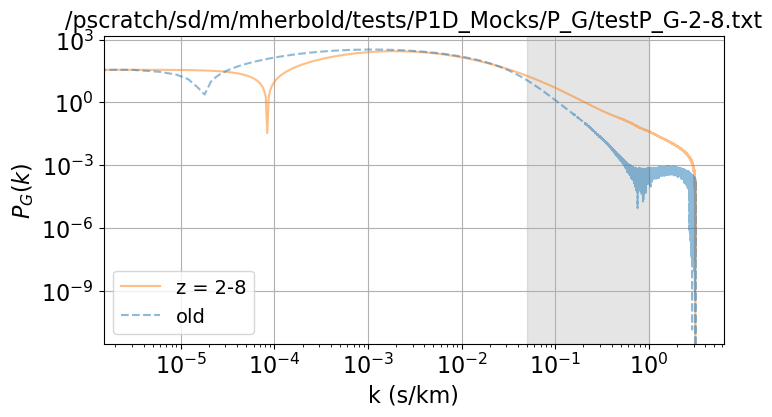

In [3]:

#### IMPORT P_G FILE ####

# PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/testP_G-{safe_z}.txt'
data = np.loadtxt(PG_file_path)

PG_file_path_old = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
data_old = np.loadtxt(PG_file_path_old)

# Split into k and P(k)
k_array = data[:, 0]
power_array = data[:, 1]

k_array_old = data_old[:, 0]
power_array_old = data_old[:, 1]


plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', 
           color='tab:orange',  ls='-', alpha=0.5)
plt.loglog(k_array_old, power_array_old, label='old', 
           color='tab:blue',  ls='--', alpha=0.5)

plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.legend()
plt.grid(True)
plt.title(f'{PG_file_path}')
plt.show()


Try importing full / half CF files and using those for PG instead

In [49]:
def mirror_xiG(safe_z):
    # Load the half CF file
    half_cf_path = f"/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_half_output.txt"
    data = np.loadtxt(half_cf_path)
    file_v = data[:, 0]         # First column
    file_xiG = data[:, 1]       # Second column

    def truncate_trailing_zeros(x, y):
        # Find the last index where y is nonzero
        last_nonzero_index = np.max(np.nonzero(y))

        # Ensure at least one zero remains at the end
        if last_nonzero_index < len(y) - 1 and y[last_nonzero_index + 1] == 0:
            last_nonzero_index += 1  # Keep the first zero after the last nonzero value

        return x[:last_nonzero_index + 1], y[:last_nonzero_index + 1]

    # v_truncated, xiG_truncated = truncate_trailing_zeros(file_v, file_xiG)
    v_truncated, xiG_truncated = file_v, file_xiG

    # Interpolate linearly (constant dv)
    file_v_fine = np.linspace(v_truncated.min(), v_truncated.max(), 2**20)
    cs = CubicSpline(v_truncated, xiG_truncated)
    file_xi_g_fine = cs(file_v_fine)

    dv_fit_fine = np.diff(file_v_fine)
    v_spacing = np.mean(dv_fit_fine)

    v_full = np.concatenate(
        [file_v_fine, file_v_fine + file_v_fine[-1] + v_spacing])

    # Mirror the correlation function values
    xig_full = np.concatenate([file_xi_g_fine, file_xi_g_fine[::-1]])

    return file_v_fine, file_xi_g_fine, v_full, xig_full



# def calc_PG(safe_z, half_or_full):

#     if half_or_full == 'half':
#         cf_option = 'half'
#     elif half_or_full == 'full':
#         cf_option = 'full'
#     else:
#         print("invalid cf option")

#     # Load CF data
#     path_to_cf = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_{cf_option}_output.txt'
#     data = np.loadtxt(path_to_cf)
#     full_v = data[:, 0]
#     full_xiG = data[:, 1]
#     full_v_spacing = full_v[1] - full_v[0]

#     # Compute power spectrum
#     file_xig_power = np.fft.rfft(full_xiG) * full_v_spacing
#     file_xig_power = np.abs(file_xig_power)  # np.abs vs .real ?
#     file_xig_karr = 2 * np.pi * \
#         np.fft.rfftfreq(len(full_xiG), d=full_v_spacing)

#     return file_xig_karr, file_xig_power


def calc_PG(safe_z, v_array, xig_array):
    full_v = v_array
    full_xiG = xig_array
    full_v_spacing = full_v[1] - full_v[0]

    # Compute power spectrum
    file_xig_power = np.fft.rfft(full_xiG) * full_v_spacing
    file_xig_power = np.abs(file_xig_power)  # np.abs vs .real ?
    file_xig_karr = 2 * np.pi * \
        np.fft.rfftfreq(len(full_xiG), d=full_v_spacing)

    return file_xig_karr, file_xig_power

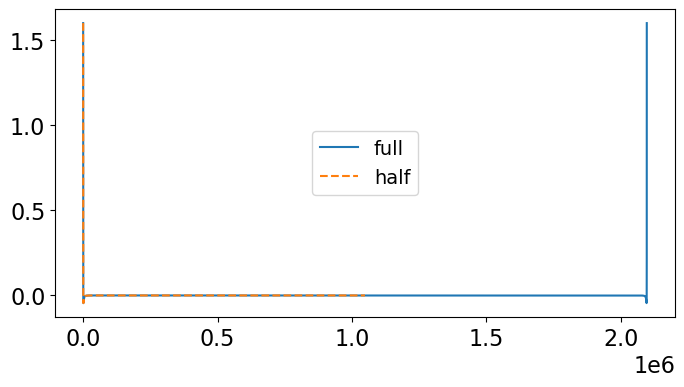

In [48]:
# load half cf from .txt file, mirror to get full

v_half, xig_half, v_full, xig_full = mirror_xiG(safe_z)

plt.plot(v_full, xig_full, label='full')
plt.plot(v_half, xig_half, label='half', ls='--')
plt.legend(loc='center')

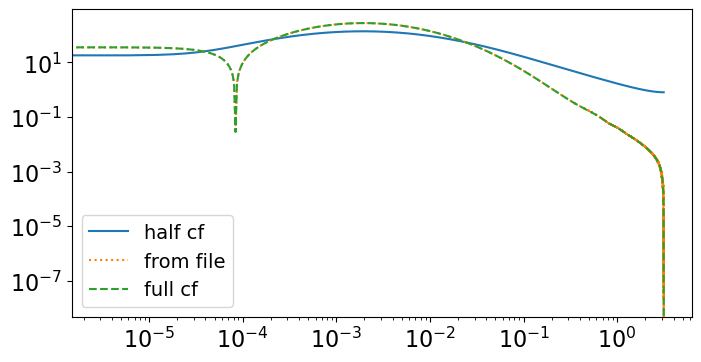

In [56]:
# test / select various k,p

# half cf
k_array_half, power_array_half = calc_PG(safe_z, v_half, xig_half)

# full cf
k_array_full, power_array_full = calc_PG(safe_z, v_full, xig_full)

# from PG file directly
k_array_file = data[:, 0]
power_array_file = data[:, 1]

plt.loglog(k_array_half, power_array_half, label='half cf')
plt.loglog(k_array_file, power_array_file, label='from file', ls='dotted')
plt.loglog(k_array_full, power_array_full, label='full cf', ls='--')
plt.legend(loc='lower left')

In [57]:

#### FUNCTIONS ####

def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # real-space size
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k [1/km]
    
    # Interpolate with smooth spline and constant extrapolation
    power_interp = InterpolatedUnivariateSpline(file_k_array, 
                                                file_power_array, 
                                                k=1, ext=1)
    P_k = power_interp(k)

    # Ensure non-negative and finite
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)

    # Scale the white noise in k-space
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse FFT to get real-space correlated Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N) / dv

    return delta_b_tilde, delta_b, P_k


def a2_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)


def a_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))


# note: variance of the field, vs the one set by mean flux (?)
def lognormal_transform(delta_z, sigma2_z):
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)


def t_of_z(zp, tau0=tau0_fid, tau1=tau1_fid, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)


def x_of_z(t_z, n_z):
    return t_z * n_z


def f_of_z(x_z):
    return np.exp(-x_z)


def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)


def xz(z, sigma2=sigma2_fid, tau0=tau0_fid, tau1=tau1_fid, 
       nu=nu_fid, z0=PD13_PIVOT_Z):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)


def mean_flux(z, variance, z0=PD13_PIVOT_Z):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - 
                                 ((xz(z)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)


def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)


def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = input_flux.mean()
    # f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)


def P_F(delta_f, dv):
    L = delta_f.size * dv
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / L
    return P_F


def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f, dv)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # w_k =  (kmodes > 0) & (kmodes < 10e1)   
    w_k =  (kmodes > 0) & (kmodes < 10e2)   
    bins = 20000
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[w_k],
                                                       values=power[w_k],
                                                       statistic='mean', 
                                                       bins = bins)    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
 
    window = (bin_centers > 0) & (bin_centers < 1.0)  

    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)
    
    return bin_centers[window], statistic[window], *popt_mock
    # return bin_centers, statistic, *popt_mock


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


DESI_EDR_PARAMETERS = (
    # 7.63089e-02, -2.52054e+00, -1.27968e-01,
    # 3.67469e+00, 2.85951e-01, 7.33473e+02)
    0.066, -2.685, -0.22,
    3.59, -0.16, 0.053) # from 2023 edr paper


Naim_2020_param = (
    0.066, -2.685, -0.22, 
    3.59, -0.18, 0.53)

In [80]:
#### MOCK GENERATION ####

gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) #+ 1e-12 

# delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
#     k_array, power_array, gaussian_random_field_k, dv)

delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array_file, power_array_file, gaussian_random_field_k, dv)

variance_1d = sigma2_fid
variance_1d_field = delta_b_v.var()

delta_b_z = delta_b_v * a_z(zp = target_redshift)

redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)
redshifted_variance_1d_field = variance_1d_field * a2_z(zp = target_redshift)

# n_z = lognormal_transform(delta_b_z, variance_1d)
n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
# n_z = lognormal_transform(delta_b_z, redshifted_variance_1d_field)
# n_z = lognormal_transform(delta_b_z, variance_1d_field)
t_z = t_of_z(zp=target_redshift)
x_z = x_of_z(t_z, n_z)
f_z = f_of_z(x_z)



In [81]:
print(f'variance_1d:       {variance_1d}')
print(f'variance_1d_field: {variance_1d_field}\n')

print(f'redshifted_variance_1d:       {redshifted_variance_1d}')
print(f'redshifted_variance_1d_field: {redshifted_variance_1d_field}')

variance_1d:       1.50381
variance_1d_field: 1.6082742479003476

redshifted_variance_1d:       1.6801535144720567
redshifted_variance_1d_field: 1.7968677092482912


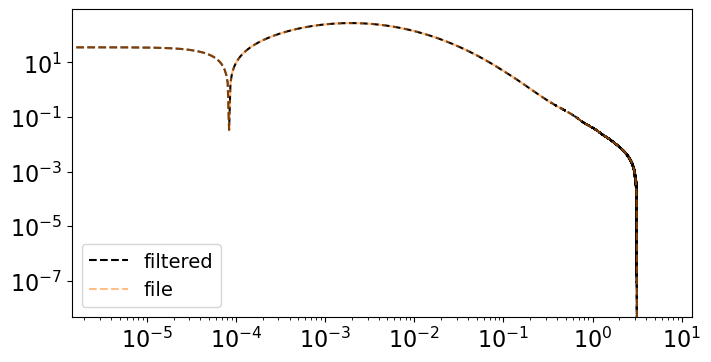

In [82]:
# plt.loglog(kmodes[1:], P_k_filtered[1:], label='filtered', color='black', ls='--')
plt.loglog(kmodes, P_k_filtered, label='filtered', color='black', ls='--')


plt.loglog(k_array, power_array, label=f'file', 
           color='tab:orange',  ls='--', alpha=0.5)


# plt.xlim(10e-12)
plt.legend(loc='lower left')

In [83]:

# #### CHECK MEAN FLUX ####

# z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3.0, 
#                    3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])
# flux_list = []
# for i in z_list:
#     flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
# turner_flux = turner24_mf(z_list)
# residuals = 100 * (flux_list - turner_flux) / turner_flux

# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
#                                gridspec_kw={'height_ratios': [3, 1]}, 
#                                constrained_layout=True)

# ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
# ax1.plot(z_list, flux_list, label='Mock', ls='--', color='black')
# ax1.plot(target_redshift, f_z.mean(), 's')
# ax1.set_ylabel(r'$\bar F(z)$')
# ax1.legend(loc='lower left')
# ax1.grid()

# ax2.axhline(0, color='gray', lw=1, ls=':')
# ax2.plot(z_list, residuals, marker='o', color='darkred')
# ax2.set_xlabel('z')
# ax2.set_ylabel('% Diff')
# ax2.grid()
# plt.show()

# print(f'mean_flux:       {mean_flux(target_redshift, variance_1d_field)}')
# print(f'flux.mean():     {f_z.mean()}')
# print(f'difference:      {np.abs(mean_flux(target_redshift, variance_1d_field) - f_z.mean())}')
# print(f'% diff (turner): {np.abs((f_z.mean() - turner24_mf(target_redshift))/turner24_mf(target_redshift) * 100)}')


In [84]:

#### MEASURE POWER ####

# delta_f = delta_F(z=target_redshift, 
#                   variance=variance_1d, 
#                   input_flux=f_z)
delta_f = delta_F(z = target_redshift, 
                  variance = variance_1d_field, 
                  input_flux = f_z)

test_power = P_F(delta_f, dv)

bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, 
                                                      target_redshift)

mock_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *popt_mock_param)
desi_model = evaluatePD13Lorentz((bin_centers, target_redshift), 
                                 *DESI_EDR_PARAMETERS)
naim_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *Naim_2020_param)

percent_diff_mock_measure = 100 * (stat - desi_model) / desi_model
percent_diff_mock_fit     = 100 * (mock_fit - desi_model) / desi_model
percent_diff_naim_fit     = 100 * (naim_fit - desi_model) / desi_model


/tmp/ipykernel_2039809/3329873480.py:125: RuntimeWarning: overflow encountered in power
  result = (A * np.pi / PD13_PIVOT_K) * np.power(
/tmp/ipykernel_2039809/3329873480.py:125: RuntimeWarning: overflow encountered in multiply
  result = (A * np.pi / PD13_PIVOT_K) * np.power(
/tmp/ipykernel_2039809/3329873480.py:129: RuntimeWarning: overflow encountered in power
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_2039809/3329873480.py:129: RuntimeWarning: invalid value encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)


In [85]:
# 2023 edr measurement k-bins
z_2_0_wk = (bin_centers > 0.001250) & (bin_centers < 0.021170)
z_2_2_wk = (bin_centers > 0.000750) & (bin_centers < 0.023753)
z_2_4_wk = (bin_centers > 0.000750) & (bin_centers < 0.023753)
z_2_8_wk = (bin_centers > 0.000750) & (bin_centers < 0.026651)
z_3_0_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_2_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_4_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_6_wk = (bin_centers > 0.000750) & (bin_centers < 0.033552)
z_3_8_wk = (bin_centers > 0.000750) & (bin_centers < 0.033552)

# 2020 mock paper k-range
wk_2020 = (bin_centers > 0.0005) & (bin_centers < 0.112)

# EDR measurement k-range
wk_2023 = (bin_centers > 0.000750) & (bin_centers < 0.035) # EDR measurement 

# 2025 measurement k-range
c = 299792.458        # km/s
delta_lambda = 0.8    # Angstrom (DESI)
lambda_lya = 1215.67  # Angstrom

def get_k_range_desi2025(z):
    """Return kmin and kmax (in s/km) for DESI DR1 resolution at redshift z."""
    R_z = (c * delta_lambda) / ((1 + z) * lambda_lya)
    k_max = 0.5 * np.pi / R_z  # s/km
    k_min = 0.001  # s/km, fixed by continuum limit
    return k_min, k_max

dynamic_k_min, dynamic_k_max = get_k_range_desi2025(target_redshift)
wk_2025 = (bin_centers > dynamic_k_min) & (bin_centers < dynamic_k_max) 



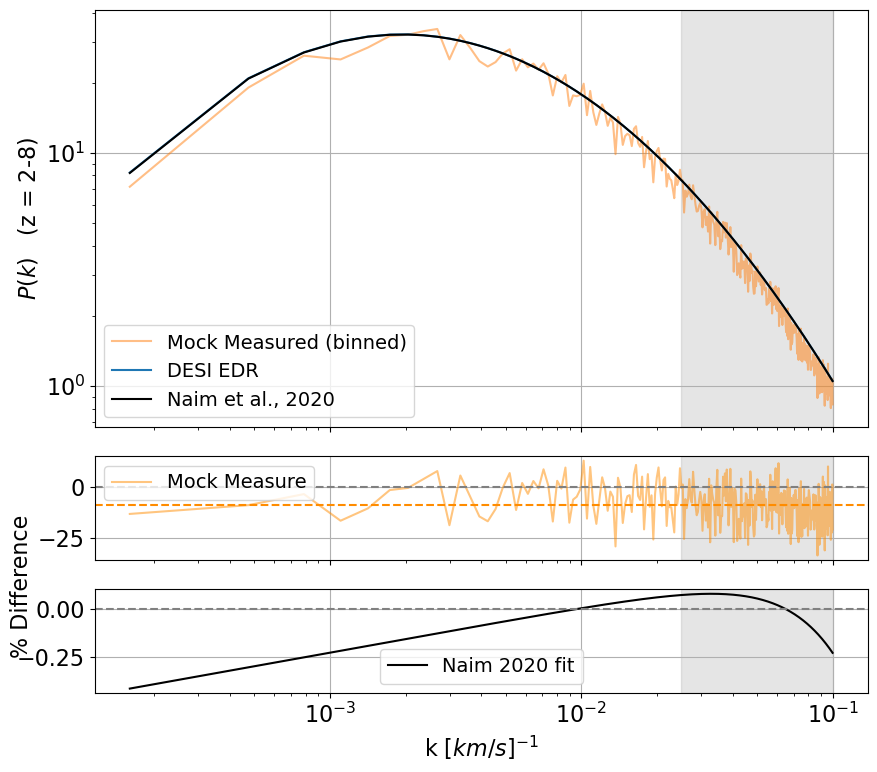

In [86]:

#### PLOT MEASURED POWER ####

w_k = (bin_centers > 1e-5) & (bin_centers < 0.1) 
# w_k = (bin_centers > 1e-3) & (bin_centers < 0.045) # EDR measurement 
# w_k = (bin_centers > 0.0005) & (bin_centers < 0.112)  # 2020 mock paper
# w_k = wk_2023



fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True, 
                                    gridspec_kw={'height_ratios': [4, 1, 1]})

ax1.loglog(bin_centers[w_k], stat[w_k], color='tab:orange', 
           label='Mock Measured (binned)', alpha=0.5)
# ax1.loglog(bin_centers[w_k], mock_fit[w_k], color='tab:orange', 
#            label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
           color='tab:blue', label=r'DESI EDR')
ax1.loglog(bin_centers[w_k], naim_fit[w_k], 
    color='black', label=r'Naim et al., 2020')
# ax1.axvline(0.045)


# ax1.loglog(kmodes, test_power, alpha=0.2, label='unbinned')

# ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.set_ylabel(rf'$P(k)$   (z = {safe_z})')
ax1.legend(loc='lower left')
ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')
ax1.axvspan(0.025, 0.1, alpha=0.2, color='grey')


ax2.semilogx(bin_centers[w_k], percent_diff_mock_measure[w_k], alpha=0.5,
             color='darkorange', label='Mock Measure')
ax2.axhline(percent_diff_mock_measure[w_k].mean(), ls='--', color='darkorange')
# ax2.semilogx(bin_centers, percent_diff_mock_fit, 
#              color='darkred', label='Mock Fit')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')
ax2.axvspan(0.025, 0.1, alpha=0.2, color='grey')


ax3.semilogx(bin_centers[w_k], percent_diff_naim_fit[w_k], 
             color='black', label='Naim 2020 fit')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'k $[km/s]^{-1}$')
# ax3.set_ylabel('% Diff')
ax3.grid(True)
ax3.axvspan(0.025, 0.1, alpha=0.2, color='grey')

fig.text(0.02, 0.25, "% Difference", va='center', rotation='vertical', fontsize=16)
ax3.set_ylabel("")  # remove individual y-labels to avoid overlap

plt.legend()
plt.tight_layout()

# plt.xlim(10e-4, 10e-2)
# ax1.set_ylim(10e-2, 10e2)

# plt.show()

# print(f'MH Average % difference: {percent_diff_mock_measure[w_k].mean()}')
# print(f'MH Max % difference:     {np.abs(percent_diff_mock_measure[w_k]).max()}\n')

# print(f'N20 Average % difference: {percent_diff_naim_fit[w_k].mean()}')
# print(f'N20 Max % difference:     {np.abs(percent_diff_naim_fit[w_k]).max()}')


In [87]:
print('2020 k-range (Lite)')
print(f'MH Average % difference: {percent_diff_mock_measure[wk_2020].mean()}')
print(f'MH Max % difference:     {np.abs(percent_diff_mock_measure[wk_2020]).max()}\n')

print(f'N20 Average % difference: {percent_diff_naim_fit[wk_2020].mean()}')
print(f'N20 Max % difference:     {np.abs(percent_diff_naim_fit[wk_2020]).max()}\n\n')

print('2023 k-range (EDR)')
print(f'MH Average % difference: {percent_diff_mock_measure[wk_2023].mean()}')
print(f'MH Max % difference:     {np.abs(percent_diff_mock_measure[wk_2023]).max()}\n')

print(f'N20 Average % difference: {percent_diff_naim_fit[wk_2023].mean()}')
print(f'N20 Max % difference:     {np.abs(percent_diff_naim_fit[wk_2023]).max()}\n\n')

print('2025 k-range (DR1)')
print(f'MH Average % difference: {percent_diff_mock_measure[wk_2025].mean()}')
print(f'MH Max % difference:     {np.abs(percent_diff_mock_measure[wk_2025]).max()}\n')

print(f'N20 Average % difference: {percent_diff_naim_fit[wk_2025].mean()}')
print(f'N20 Max % difference:     {np.abs(percent_diff_naim_fit[wk_2025]).max()}')

2020 k-range (Lite)
MH Average % difference: -8.978182308429828
MH Max % difference:     33.35792630274756

N20 Average % difference: -0.040566374308789475
N20 Max % difference:     0.33393029237021554


2023 k-range (EDR)
MH Average % difference: -5.2174658950492985
MH Max % difference:     28.94390760751924

N20 Average % difference: 0.02431591980074253
N20 Max % difference:     0.24951434881828605


2025 k-range (DR1)
MH Average % difference: -4.6661674753344435
MH Max % difference:     28.94390760751924

N20 Average % difference: 0.018083555733821227
N20 Max % difference:     0.2152164749641353


In [88]:
def compute_rms_error(P_mock, P_target, mask=None):
    if mask is not None:
        P_mock = P_mock[mask]
        P_target = P_target[mask]
    frac_diff = (P_mock - P_target) / P_target
    return np.sqrt(np.mean(frac_diff**2))

rms_new_2020 = compute_rms_error(stat, desi_model, wk_2020)
rms_old_2020 = compute_rms_error(naim_fit, desi_model, wk_2020)

rms_new_2023 = compute_rms_error(stat, desi_model, wk_2023)
rms_old_2023 = compute_rms_error(naim_fit, desi_model, wk_2023)

rms_new_2025 = compute_rms_error(stat, desi_model, wk_2025)
rms_old_2025 = compute_rms_error(naim_fit, desi_model, wk_2025)

print('2020 Mask (Lite)')
print(f'This Work RMS (z = {safe_z}):  {rms_new_2020:.4f}')
print(f'N20 RMS       (z = {safe_z}):  {rms_old_2020:.4f}')

print('\n2023 Mask (EDR)')
print(f'This Work RMS (z = {safe_z}):  {rms_new_2023:.4f}')
print(f'N20 RMS       (z = {safe_z}):  {rms_old_2023:.4f}')

print('\n2025 Mask (DR1)')
print(f'This Work RMS (z = {safe_z}):  {rms_new_2025:.4f}')
print(f'N20 RMS       (z = {safe_z}):  {rms_old_2025:.4f}')



2020 Mask (Lite)
This Work RMS (z = 2-8):  0.1306
N20 RMS       (z = 2-8):  0.0013

2023 Mask (EDR)
This Work RMS (z = 2-8):  0.1069
N20 RMS       (z = 2-8):  0.0008

2025 Mask (DR1)
This Work RMS (z = 2-8):  0.1023
N20 RMS       (z = 2-8):  0.0007


In [74]:
# plt.semilogx(bin_centers[wk_2020], percent_diff_mock_measure[wk_2020], alpha=0.5,
#              color='darkorange', label=f'z = {target_redshift}')
# plt.axhline(percent_diff_mock_measure[wk_2020].mean(), ls='--', color='darkorange')
# plt.legend()

In [75]:
# temp_window = (kmodes > 1e-5) & (kmodes < 0.1) 


# plt.loglog(bin_centers[w_k], desi_model[w_k], 
#            color='tab:blue', label=r'DESI EDR')
# plt.loglog(kmodes[temp_window],test_power[temp_window], color='tab:orange', 
#            label=f'measured z = {target_redshift}', alpha=0.5)
# plt.legend()

In [76]:
# def compute_rms_error(P_mock, P_target):
#     frac_diff = (P_mock - P_target) / P_target
#     return np.sqrt(np.mean(frac_diff**2))

# rms_new = compute_rms_error(stat, desi_model)
# rms_old = compute_rms_error(naim_fit, desi_model)

# # print(f'This Work RMS  z = {safe_z}:  {rms_new}')
# # print(f'N20 RMS        z = {safe_z}:  {rms_old}')

In [77]:
# plt.plot(f_z[1:10000], label=f'F (z = {target_redshift})')
# plt.axhline(f_z.mean(), ls='--', color='tab:red', label=rf'${{F}}$(z).mean() = {f_z.mean():.2f}')
# plt.axhline(turner24_mf(target_redshift), ls='--', color='tab:green', label=rf'Turner $\overline{{F}}(z)$ = {turner24_mf(target_redshift):.2f}')
# plt.legend(loc='upper left')

# print(f'Measured mean flux:      {f_z.mean()}')
# print(f'Turner et al. mean flux: {turner24_mf(target_redshift)}')
# print(f'Difference:              {turner24_mf(target_redshift)-f_z.mean()}')
# print(f'% Difference:            {np.abs((f_z.mean() - turner24_mf(target_redshift))/turner24_mf(target_redshift) * 100)}')


### COMPARE TO DESI EDR DATA

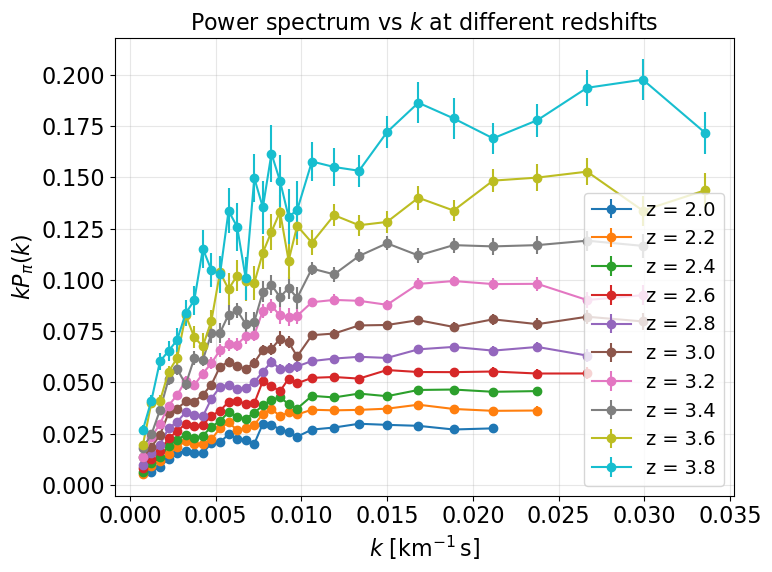

In [89]:
import pandas as pd

edr_data_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Examples/figure8_qmle_desiedrp_results.txt'

# Read the file, using '|' as a separator and stripping whitespace
df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
df = df.apply(pd.to_numeric)               # Ensure all data is numeric

# Group by redshift and plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for z_val, group in df.groupby('z'):
    plt.errorbar(group['kc'], group['kPpi'], yerr=group['kepi'], fmt='o-', label=f'z = {z_val}')

plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$kP_{\pi}(k)$')
plt.title("Power spectrum vs $k$ at different redshifts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



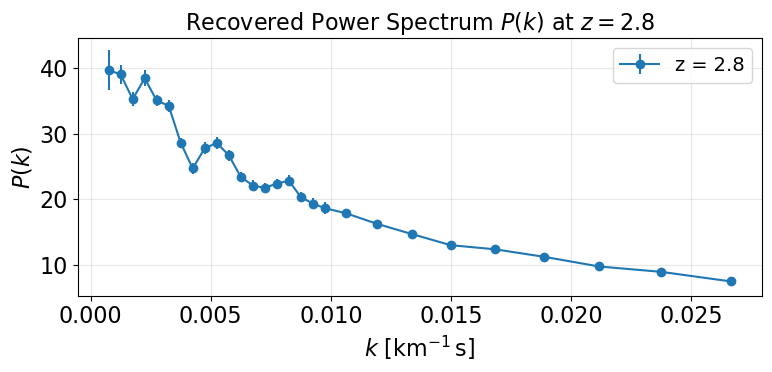

In [90]:
z_target = target_redshift
subset = df[df['z'] == z_target].copy()

# Recover P(k) and its uncertainty
subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

# Plot
plt.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], fmt='o-', label=f'z = {z_target}')
plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$P(k)$')
plt.title(f"Recovered Power Spectrum $P(k)$ at $z={z_target}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# print(f'kmin = {subset['kc'][:].min()}')
# print(f'kmax = {subset['kc'][:].max()}')



In [94]:
# 2023 edr measurement k-bins

z_2_0_wk = (bin_centers > 0.001250) & (bin_centers < 0.021170)
z_2_2_wk = (bin_centers > 0.000750) & (bin_centers < 0.023753)
z_2_4_wk = (bin_centers > 0.000750) & (bin_centers < 0.023753)
z_2_8_wk = (bin_centers > 0.000750) & (bin_centers < 0.026651)
z_3_0_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_2_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_4_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_6_wk = (bin_centers > 0.000750) & (bin_centers < 0.033552)
z_3_8_wk = (bin_centers > 0.000750) & (bin_centers < 0.033552)




In [95]:
def process_EDR_DATA(z_target):
    edr_data_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Examples/figure8_qmle_desiedrp_results.txt'

    # Read the file, using '|' as a separator and stripping whitespace
    df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
    df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
    df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
    df = df.apply(pd.to_numeric)               # Ensure all data is numeric

    subset = df[df['z'] == z_target].copy()
    
    # Recover P(k) and its uncertainty
    subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
    subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

    return subset['kc'], subset['Pk'], subset['Pk_err']

test_edr_k, test_edr_p, test_edr_err = process_EDR_DATA(target_redshift)

In [96]:
# plt.errorbar(test_edr_k, test_edr_p, test_edr_err, marker='o')

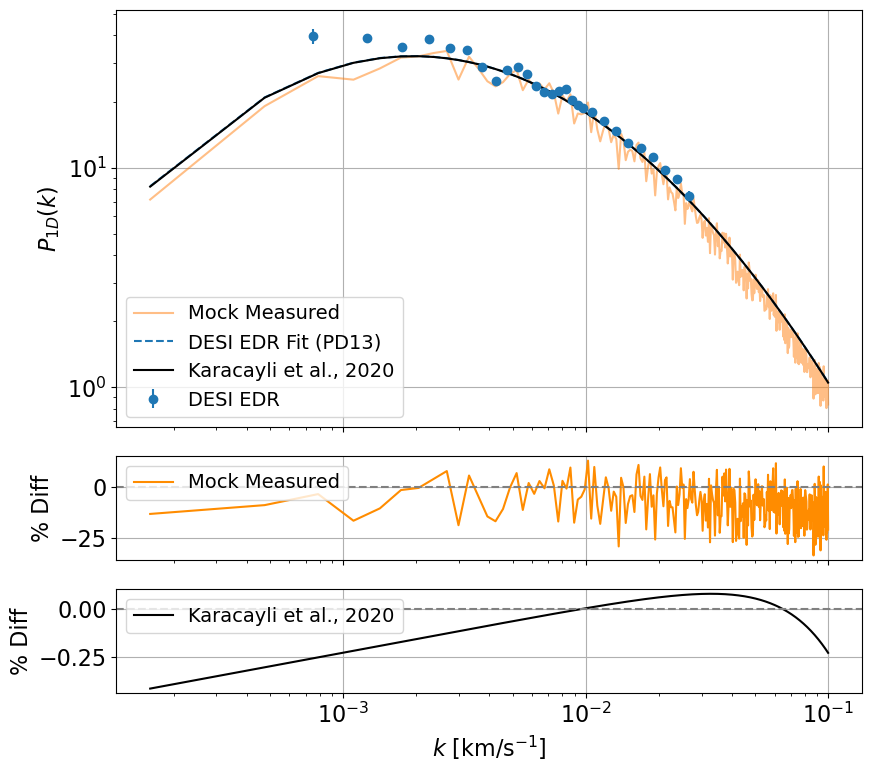

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1, 1]})

mask = (bin_centers > 1e-5) & (bin_centers < 0.1) 


# Upper plot
ax1.loglog(bin_centers[mask], stat[mask], color='tab:orange', label='Mock Measured', alpha=0.5)
# ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[mask], desi_model[mask], 
    color='tab:blue', label=r'DESI EDR Fit (PD13)', ls='--')
ax1.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], 
             fmt='o', label='DESI EDR', color='tab:blue')#, markerfacecolor='none')
ax1.loglog(bin_centers[mask], naim_fit[mask], 
    color='black', label=r'Karacayli et al., 2020')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock P1D at z = {safe_z} (2025 Mask)')

# Lower plot (residuals)
ax2.semilogx(bin_centers[mask], percent_diff_mock_measure[mask], color='darkorange', label='Mock Measured')
# ax2.semilogx(bin_centers, percent_diff1, color='darkred', label='Mock Fit')
# ax2.semilogx(bin_centers, percent_diff2, color='black', label='Naim 2020')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.semilogx(bin_centers[mask], percent_diff_naim_fit[mask], color='black', label='Karacayli et al., 2020')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax3.set_ylabel('% Diff')
ax3.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


In [98]:
def fit_PD13Lorentz_from_power(k_array, Pk_array, z):
    """
    Fit the PD13 Lorentzian model to a 1D flux power spectrum.

    Parameters
    ----------
    k_array : ndarray
        1D array of wavenumbers (in s/km).
    Pk_array : ndarray
        Corresponding 1D array of power spectrum values.
    z : float
        Redshift at which the fit is performed.

    Returns
    -------
    k_fit : ndarray
        Wavenumber values used in the fit (after windowing and cleaning).
    P_fit : ndarray
        Power spectrum values corresponding to `k_fit`.
    A, n, alpha, B, beta, lmd : float
        Best-fit parameters of the PD13 Lorentzian model.
    """
    # Apply windowing in k (adjust range as needed)
    window = (k_array > 0) & (k_array < 1.0)
    k_valid = k_array[window]
    P_valid = Pk_array[window]

    # Filter finite values
    valid = np.isfinite(k_valid) & np.isfinite(P_valid)
    k_fit = k_valid[valid]
    P_fit = P_valid[valid]

    # Initial parameter guess: [A, n, alpha, B, beta, lambda]
    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)

    popt_mock, _ = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz((k, z), A, n, alpha, B, beta, lmd),
        k_fit, P_fit, p0=p0, maxfev=20000
    )

    return k_fit, P_fit, *popt_mock


In [99]:
from scipy.interpolate import UnivariateSpline
import numpy as np
def smooth_power_spectrum_loglog(kc, Pk, s_factor=0.001, k_eval=None):
    """
    Smooths P(k) in log-log space using a spline.

    Useful if P(k) follows a power-law shape.

    Parameters
    ----------
    kc : ndarray
        Wavenumbers (k-values).
    Pk : ndarray
        Power spectrum values.
    s_factor : float, optional
        Smoothing factor; smaller = tighter fit.
    k_eval : ndarray, optional
        k-values at which to evaluate the spline.

    Returns
    -------
    k_smooth : ndarray
        Interpolated k-values.
    Pk_smooth : ndarray
        Interpolated and smoothed P(k) values.
    """
    mask = (kc > 0) & (Pk > 0) & np.isfinite(kc) & np.isfinite(Pk)
    log_k = np.log(kc[mask])
    log_Pk = np.log(Pk[mask])
    
    spline = UnivariateSpline(log_k, log_Pk, s=s_factor)

    if k_eval is None:
        k_eval = np.logspace(np.log10(kc[mask].min()), np.log10(kc[mask].max()), 500)
    
    return k_eval, np.exp(spline(np.log(k_eval)))


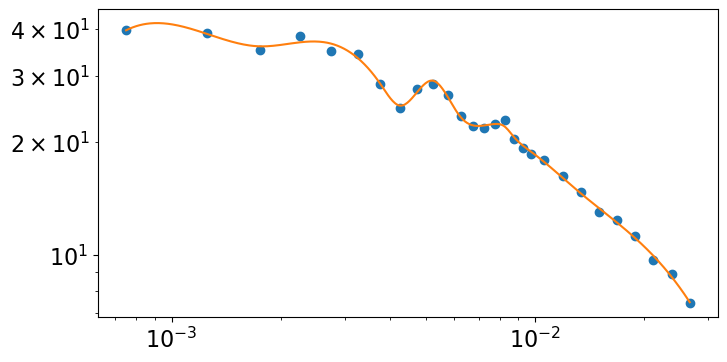

In [100]:
k_smooth, Pk_smooth = smooth_power_spectrum_loglog(subset['kc'], subset['Pk'], s_factor=0.01)

k_fit, P_fit, *popt_mock = fit_PD13Lorentz_from_power(k_smooth, Pk_smooth,2.8)

plt.loglog(subset['kc'], subset['Pk'], 'o')
plt.loglog(k_fit,P_fit)

In [101]:
popt_mock

[0.07491111606825496,
 -4.4596227760248475,
 -0.11434970172591227,
 4.739379827440588,
 -37.04152391416946,
 442.0946832039948]

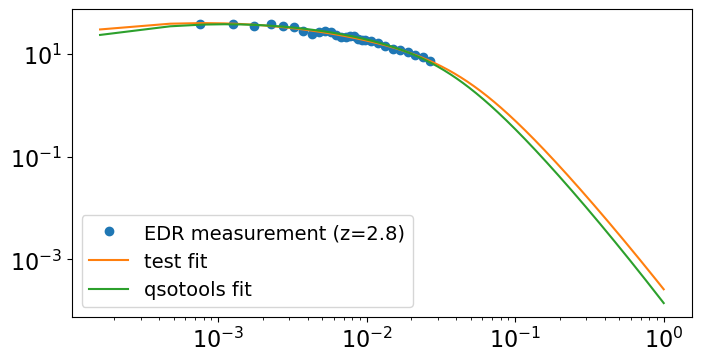

In [102]:
qsotools_params = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)


test_fit = evaluatePD13Lorentz((bin_centers, target_redshift),
                               *popt_mock)
qsotools_fit = evaluatePD13Lorentz((bin_centers, target_redshift),
                               *qsotools_params)

plt.loglog(subset['kc'], subset['Pk'], 'o', label='EDR measurement (z=2.8)')
plt.loglog(bin_centers, test_fit, label='test fit')
plt.loglog(bin_centers, qsotools_fit, label='qsotools fit')
# plt.xlim(xmax=10e-2)
# plt.ylim(ymin=10e-1)
plt.legend()

### Compare to previous Mocks (Iron) -> Lyspeq output

In [16]:
import os
import sys
import datetime
from glob import glob
from astropy.table import Table, QTable
from astropy.time import Time
from astropy.io import ascii, fits
from astropy import table 
import scipy.optimize
import time

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [17]:

# import iron data
rawdir1 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/iron_data_vs_mocks/lyspeq_ouput/data_bals_masked/tests/results/picca-true/'
file1 = rawdir1 + 'desi-iron-bal_mask-n2_it1_quadratic_power_estimate_detailed.txt'
data1 = ascii.read(file1)


# import iron mock
rawdir2 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/iron_data_vs_mocks/lyspeq_ouput/iron_mock/output/tests/results/picca-true/'
ext = 'desi-iron-bal_mask-n2_it1_quadratic_power_estimate_detailed.txt'
file2 = rawdir2 + ext
data2 = ascii.read(file2)

data2

z,k1,k2,kc,Pfid,ThetaP,Pest,ErrorP,d,b,t
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.0,0.0,0.0005,0.00025,3.996125,-0.1470204,3.849105,0.517827,6.793802,2.322297,4.618525
2.0,0.0005,0.001,0.00075,7.558553,-0.1567673,7.401786,0.1293216,14.91717,7.292221,7.781719
2.0,0.001,0.0015,0.00125,9.212059,-0.2052715,9.006788,0.1184164,17.69904,8.466578,9.437736
2.0,0.0015,0.002,0.00175,9.940814,-0.2970367,9.643777,0.1208808,18.92195,9.100219,10.11877
2.0,0.002,0.0025,0.00225,10.20364,-0.233618,9.97002,0.1220962,19.44206,9.308189,10.36749
2.0,0.0025,0.003,0.00275,10.21612,-0.1910139,10.02511,0.1222353,19.56802,9.384191,10.37484
2.0,0.003,0.0035,0.00325,10.08865,-0.1172096,9.971444,0.1216081,19.52754,9.398004,10.24675
2.0,0.0035,0.004,0.00375,9.881701,-0.2292521,9.652449,0.120635,19.15913,9.34675,10.04163
2.0,0.004,0.0045,0.00425,9.63009,-0.3911212,9.238968,0.1194754,18.6882,9.285569,9.793754


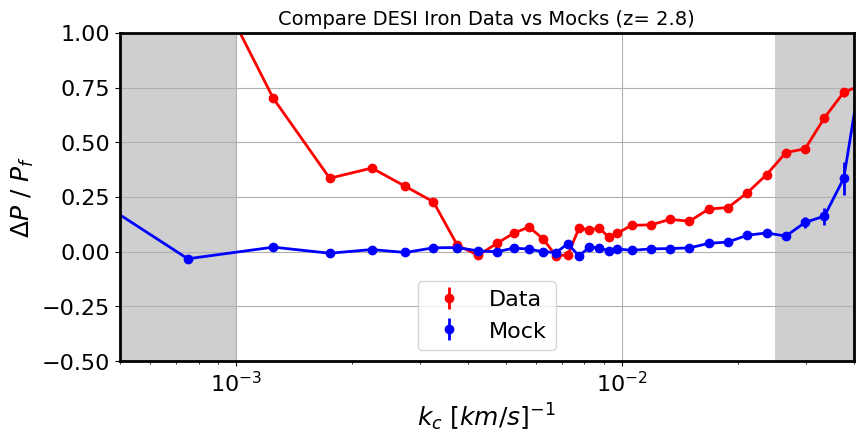

In [18]:

##################################################################
# COMPARE Iron data VS mock  (P_fid = fiducial power)
##################################################################

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4]:
for i in [2.8]:
    zmask1 = data1['z'] == i
    plt.plot(data1['kc'][zmask1], data1['ThetaP'][zmask1]/data1['Pfid'][zmask1], 
             color = 'red') 
    
    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], data2['ThetaP'][zmask2]/data2['Pfid'][zmask2], 
             color = 'blue') 
    
    plot1 = plt.errorbar(data1['kc'][zmask1], data1['ThetaP'][zmask1]/data1['Pfid'][zmask1], 
                        yerr = data1['ErrorP'][zmask1]/data1['Pfid'][zmask1],fmt ='o', 
                         label = "Data", color = 'red')

    plot2 = plt.errorbar(data2['kc'][zmask2], data2['ThetaP'][zmask2]/data2['Pfid'][zmask2], 
                        yerr = data2['ErrorP'][zmask2]/data2['Pfid'][zmask2],fmt ='o', 
                         label = "Mock", color = 'blue')
    plt.tight_layout()
    plt.xlabel("$k_c$ $[km/s]^{-1}$")
    plt.ylabel('Δ' "$P$ / $P_f$")
    plt.xscale("log")
    plt.legend()
    plt.grid()
    plt.title('Compare DESI Iron Data vs Mocks (z= ' + str(i) + ')')

    plt.ylim([-0.5, 1])
    plt.xlim([0.0005, 0.04])

    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)

    plt.show()

In [19]:
######################################################################
## USING MOCK ONLY for ALL redshifts (P_est = estimate, not fiducial)
######################################################################

plt.figure()

NUM_COLORS = 13
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]:    
    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], np.multiply(data2['kc'][zmask2],
                                              data2['Pest'][zmask2])/np.pi, 
                                             label = 'z = ' + str(i)) 
    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$k_c$$P_{est}$ / $\pi$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Mocks' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    plt.grid()
    
    # plt.ylim([-1.5, 1.5])
    # plt.xlim([0.0005, 0.045])

    #plt.show()



In [20]:
######################################################################
## USING MOCK ONLY for ALL redshifts (P_est = estimate, not fiducial)
######################################################################

plt.figure()

NUM_COLORS = 10
cm = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8]: #, 4.0, 4.2]:    
    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], data2['Pest'][zmask2], label = 'z = ' + str(i)) 
    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$P_{est}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Mocks' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    plt.grid()
    
    # plt.ylim([-1.5, 1.5])
    # plt.xlim([0.0005, 0.045])

    #plt.show()



In [21]:
######################################################################
# USING Data ONLY for ALL redshifts
######################################################################
plt.figure()

NUM_COLORS = 10
cm = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8]: #, 4.0, 4.2]:    
    zmask1 = data1['z'] == i
    plt.plot(data1['kc'][zmask1], data1['Pest'][zmask1], marker='o',
             label = 'z = ' + str(i)) 

    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$P_{est}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Data' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    
    # plt.ylim([-1.5, 1.5])
    # plt.xlim([0.0005, 0.045])

    #plt.show()


In [22]:
######################################################################
# USING Data ONLY for ALL redshifts
######################################################################
plt.figure()

NUM_COLORS = 10
cm = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8]: #, 4.0, 4.2]:    
    zmask1 = data1['z'] == i
    plt.errorbar(data1['kc'][zmask1], data1['Pest'][zmask1], 
                 data1['ErrorP'][zmask1], marker='o', label = 'z = ' + str(i)) 

    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$P_{est}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Data' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    
    plt.ylim([10e-1, 10e2])
    # plt.xlim([0.0005, 0.045])

    #plt.show()


<Figure size 800x400 with 0 Axes>

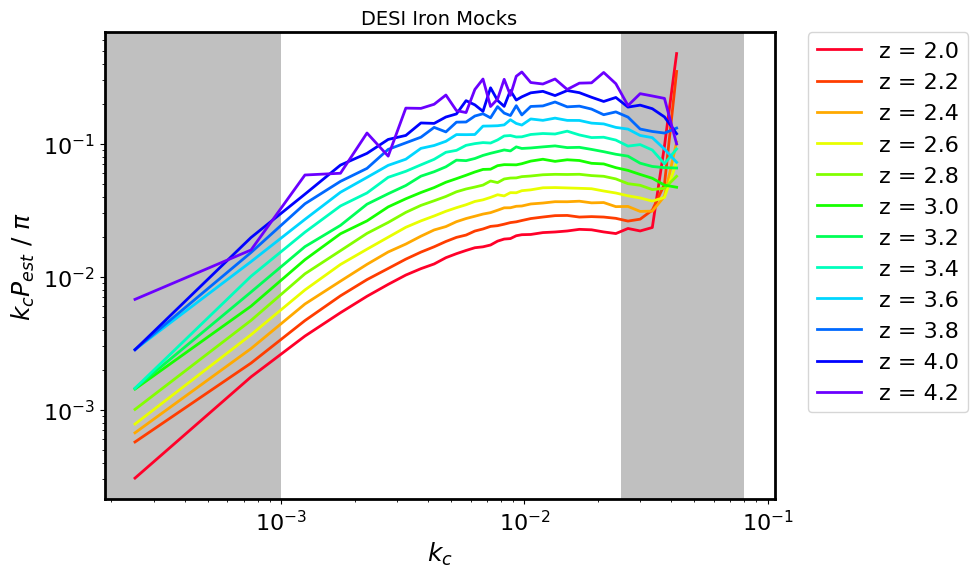

<Figure size 800x400 with 0 Axes>

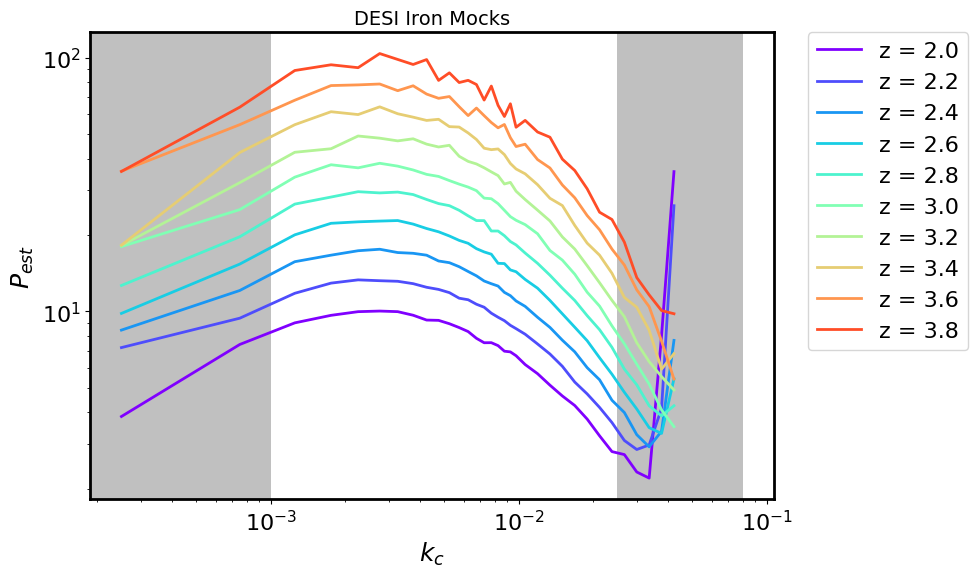

<Figure size 800x400 with 0 Axes>

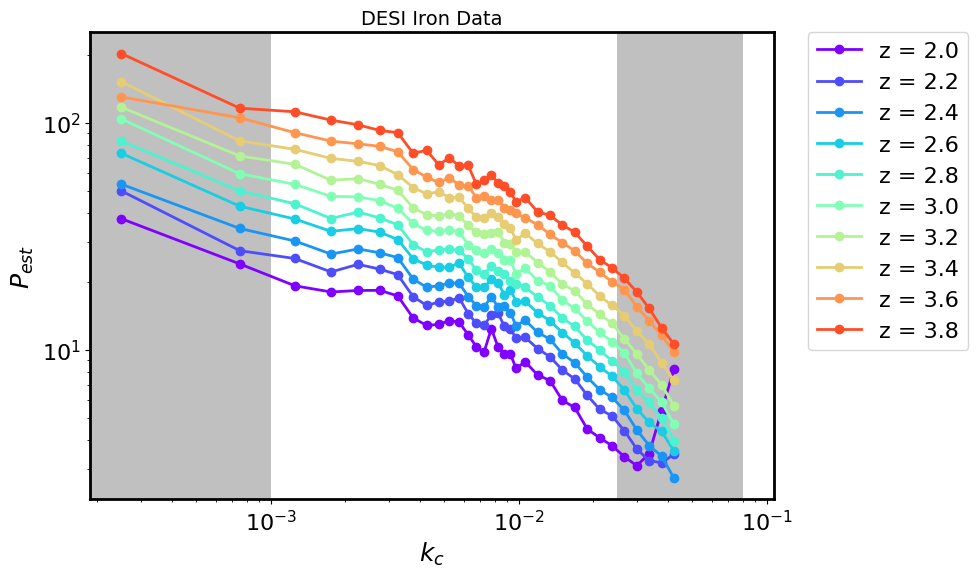

<Figure size 800x400 with 0 Axes>

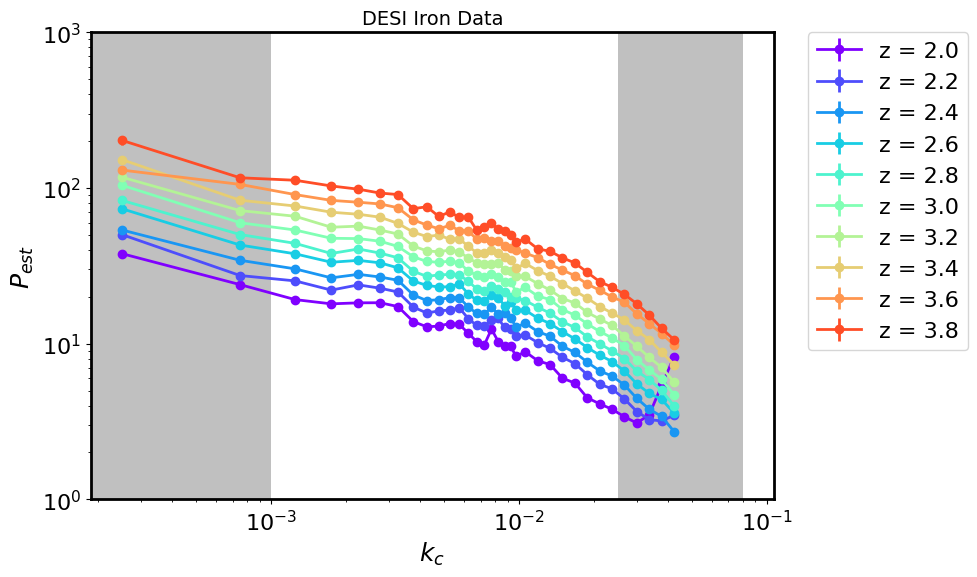

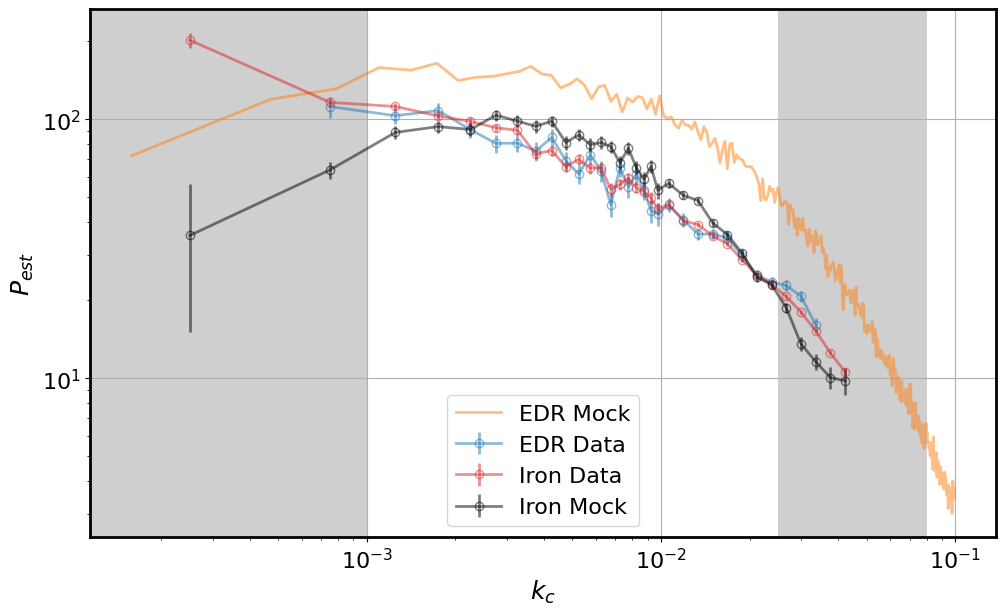

In [23]:
######################################################################
# COMPARING data and mocks
######################################################################

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8]: #, 4.0, 4.2, 4.4]:    
# for i in [3.0]: 

test_redshift = 3.8
alpha_value = 0.5

plt.figure(figsize=(10,6))
    
# EDR Data
subset = df[df['z'] == test_redshift].copy()
subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']
plt.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], markerfacecolor='none',
             fmt='-o', label='EDR Data', color='tab:blue', alpha=alpha_value)

# EDR Mocks (mine)
plt.plot(bin_centers[w_k], stat[w_k], color='tab:orange', 
           label='EDR Mock', alpha=alpha_value)

# Iron Data
zmask1 = data1['z'] == test_redshift
plot1 = plt.errorbar(data1['kc'][zmask1], data1['Pest'][zmask1], 
                     yerr = data1['ErrorP'][zmask1], fmt ='-o', markerfacecolor='none',
                     label = "Iron Data", color = 'tab:red', alpha=alpha_value)

# Iron Mocks
zmask2 = data2['z'] == test_redshift
plot2 = plt.errorbar(data2['kc'][zmask2], data2['Pest'][zmask2], 
                     yerr = data2['ErrorP'][zmask2], fmt ='-o', markerfacecolor='none',
                     label = "Iron Mock", color = 'black', alpha=alpha_value)
plt.tight_layout()
plt.xlabel("$k_c$")
plt.ylabel("$P_{est}$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
# plt.title('Compare DESI Iron Data vs Mocks (z = ' + str(test_redshift) + ')')
    
x1 = 0.025
x2 = 0.08
plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
x3 = 0.000
x4 = 0.001
plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)

plt.show()


### Compare Mean flux

31001


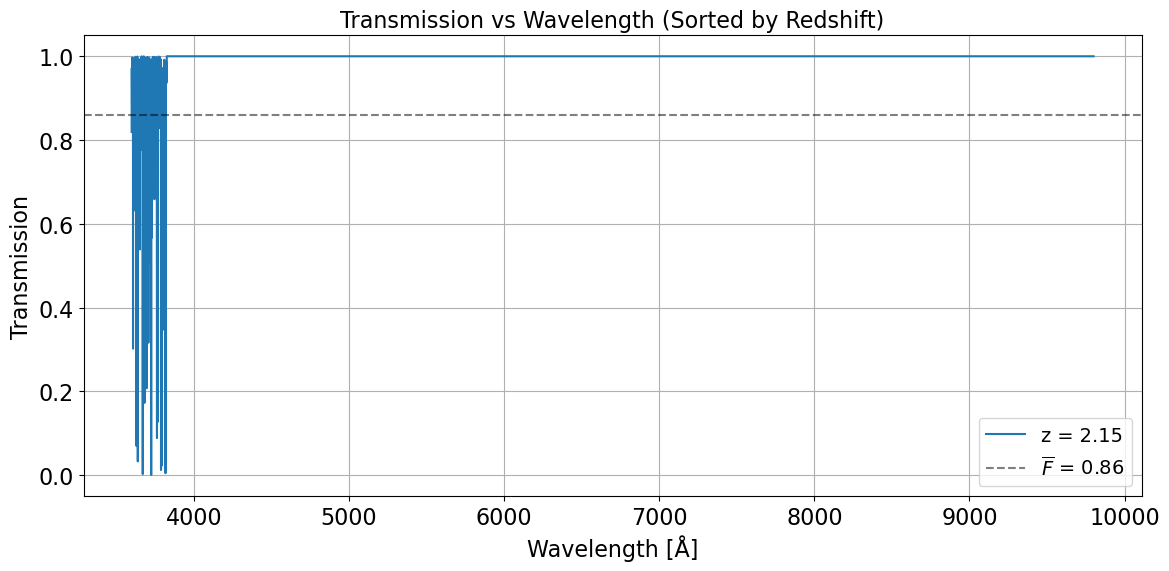

In [18]:
import fitsio
import matplotlib.pyplot as plt
import numpy as np

# EDR
path = '/global/cfs/cdirs/desicollab/users/naimgk/ohio-p1d/generic-mocks/transmissions/3/306/lya-transmission-16-306.fits.gz'

# Iron
# path = '/global/cfs/cdirs/desicollab/users/naimgk/ohio-p1d/v2.0/iron/main/QSO_cat_iron_main_dark_healpix_v0/v2.0.1/transmissions/9/939/lya-transmission-16-939.fits.gz'

with fitsio.FITS(path) as f:
    meta = f[1].read()
    wavelength = f[2].read()              # shape (31001,)
    transmission = f[3].read()            # shape (31001, 34) → needs transpose

# Transpose so each row is a spectrum
transmission = transmission.T             # shape becomes (34, 31001)

# Extract and sort by redshift
z = meta['Z']
sort_idx = np.argsort(z)
z_sorted = z[sort_idx]
trans_sorted = transmission[sort_idx]

# Plot a few spectra at evenly spaced redshifts
n_plot = 1
indices = np.linspace(0, len(z_sorted) - 1, n_plot, dtype=int)

plt.figure(figsize=(12, 6))
for i in indices:
    plt.plot(wavelength, trans_sorted[i], label=f"z = {z_sorted[i]:.2f}")
    print(wavelength.size)
    plt.axhline(trans_sorted[i][0:900].mean(), ls='--', color='black', alpha=0.5, 
                label=rf'$\overline{{F}}$ = {trans_sorted[i][0:900].mean():.2f}')

plt.xlabel("Wavelength [Å]")
plt.ylabel("Transmission")
plt.title("Transmission vs Wavelength (Sorted by Redshift)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

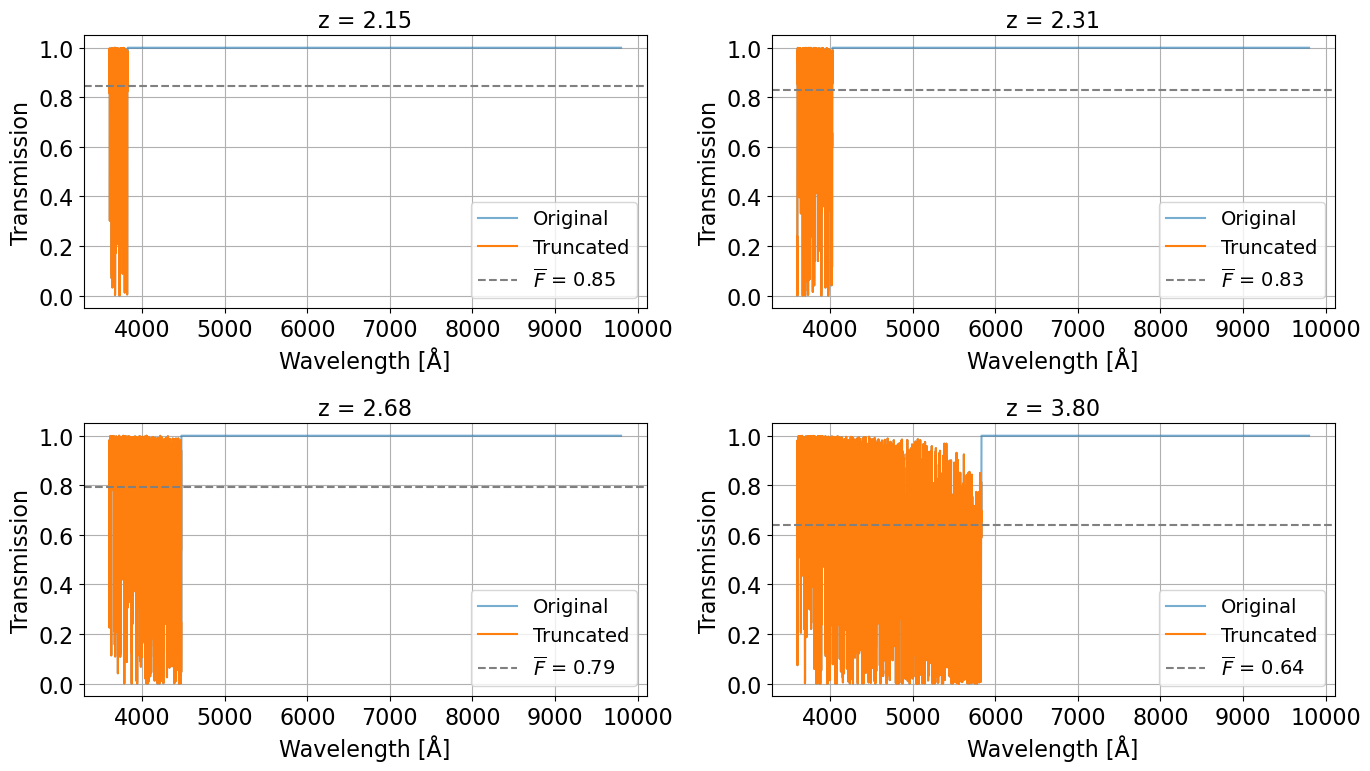

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def truncate_at_flatline(trans, threshold=0.999, min_run_length=50):
    above = trans > threshold
    run_length = 0
    for i in range(len(above)):
        if above[i]:
            run_length += 1
            if run_length >= min_run_length:
                return trans[:i - min_run_length + 1]  # cut before flatline starts
        else:
            run_length = 0
    return trans  # no flatline found

# Choose a few redshifted spectra to test visually
test_indices = np.linspace(0, len(trans_sorted) - 1, 4, dtype=int)

plt.figure(figsize=(14, 8))
for i, idx in enumerate(test_indices):
    original = trans_sorted[idx]
    truncated = truncate_at_flatline(original)
    wave = wavelength[:len(original)]

    plt.subplot(2, 2, i + 1)
    plt.plot(wave, original, label='Original', alpha=0.6)
    plt.plot(wave[:len(truncated)], truncated, label='Truncated', color='C1')
    plt.axhline(np.mean(truncated), color='gray', linestyle='--',
                label=rf'$\overline{{F}}$ = {np.mean(truncated):.2f}')
    plt.title(f"z = {z_sorted[idx]:.2f}")
    plt.xlabel("Wavelength [Å]")
    plt.ylabel("Transmission")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


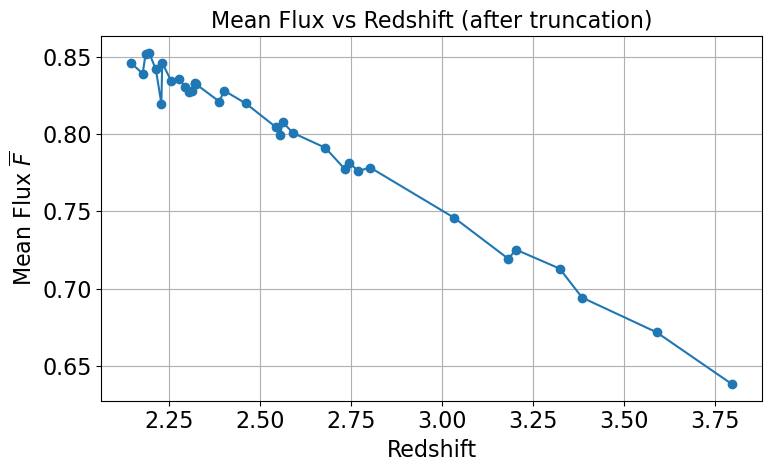

In [20]:
# Apply to all spectra
mean_fluxes = []
for spec in trans_sorted:
    truncated = truncate_at_flatline(spec)
    mean_fluxes.append(np.mean(truncated))

mean_fluxes = np.array(mean_fluxes)

# Plot mean flux vs redshift
plt.figure(figsize=(8, 5))
plt.plot(z_sorted, mean_fluxes, marker='o', linestyle='-', color='C0')
plt.xlabel("Redshift")
plt.ylabel(r"Mean Flux $\overline{F}$")
plt.title("Mean Flux vs Redshift (after truncation)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
z_list

array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

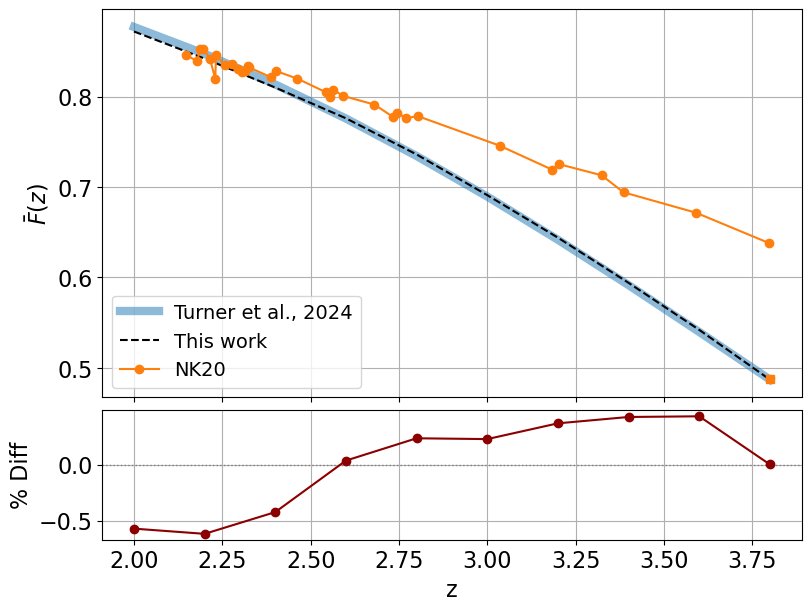

In [22]:

#### CHECK MEAN FLUX ####

z_list = np.arange(2.0, 4.0, 0.2)

# flux_list = turner_flux*1.005 # temp

flux_list = [0.872, 0.842, 0.810, 0.776, 0.736, 
            0.691, 0.644, 0.594, 0.542, 0.487]  # this work, get from gen_mock flux plot

turner_flux = turner24_mf(z_list)
residuals = 100 * (flux_list - turner_flux) / turner_flux

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
                               gridspec_kw={'height_ratios': [3, 1]}, 
                               constrained_layout=True)

ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(z_list, flux_list, label='This work', ls='--', color='black')
ax1.plot(z_sorted, mean_fluxes, marker='o', linestyle='-', color='tab:orange', label='NK20')


ax1.plot(target_redshift, f_z.mean(), 's')
ax1.set_ylabel(r'$\bar F(z)$')
ax1.legend(loc='lower left')
ax1.grid()

ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(z_list, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()
plt.show()


In [23]:
# Step 1: Setup and sorting
import numpy as np
import fitsio
from collections import defaultdict

# Load file
with fitsio.FITS(path) as f:
    meta = f[1].read()
    wavelength = f[2].read()
    transmission = f[3].read().T  # Shape: (34, 31001)

z = meta['Z']
sort_idx = np.argsort(z)
z_sorted = z[sort_idx]
trans_sorted = transmission[sort_idx]

# Step 2: Group by redshift with small tolerance
dz_tol = 0.025
z_groups = defaultdict(list)

for i, zi in enumerate(z_sorted):
    found = False
    for z_key in z_groups:
        if abs(zi - z_key) < dz_tol:
            z_groups[z_key].append(trans_sorted[i])
            found = True
            break
    if not found:
        z_groups[zi].append(trans_sorted[i])

# Step 3: Mean flux calculation with cutoff detection
def trimmed_mean_flux(spectrum):
    flat_idx = np.where(spectrum == 1)[0]
    if len(flat_idx) == 0:
        return spectrum.mean()
    for j in range(len(flat_idx) - 20):
        if np.all(spectrum[flat_idx[j]:flat_idx[j]+20] == 1):
            return spectrum[:flat_idx[j]].mean()
    return spectrum.mean()

z_group_keys = sorted(z_groups)
mean_fluxes_grouped = []

for z_val in z_group_keys:
    group_fluxes = [trimmed_mean_flux(spec) for spec in z_groups[z_val]]
    mean_fluxes_grouped.append(np.mean(group_fluxes))

z_group_keys = np.array(z_group_keys)
mean_fluxes_grouped = np.array(mean_fluxes_grouped)


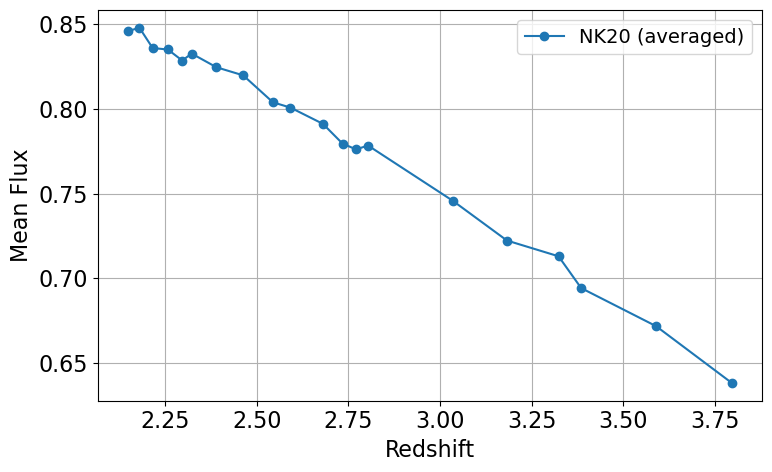

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(z_group_keys, mean_fluxes_grouped, 'o-', label="NK20 (averaged)")
plt.xlabel("Redshift")
plt.ylabel("Mean Flux")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# quantify improvement in mean flux

flux_new = np.array(flux_list)      # from your updated model ("This work")
flux_old = np.array(mean_fluxes_grouped)    # from NK20 mock measurement
flux_target = np.array(turner_flux) # from Turner et al., 2024


In [26]:
# def rms_error(measured, target):
#     return np.sqrt(np.mean(((measured - target) / target)**2))

def abs_rms_error(measured, target):
    return np.sqrt(np.mean((measured - target)**2))



def compute_rms_error(measured, target, mask=None): # to be consistent with P1D def RMS
    if mask is not None:
        measured = measured[mask]
        target = target[mask]
    frac_diff = (measured - target) / target
    return np.sqrt(np.mean(frac_diff**2))

def mape(measured, target):
    return np.mean(np.abs((measured - target) / target)) * 100

def MPD(measured, target):
    return np.max(np.abs(100 * (measured - target) / target))


rms_new = compute_rms_error(flux_new, flux_target)
rms_old = compute_rms_error(flux_old[:len(flux_target)], flux_target)

print(f"Frac RMS Error (This work): {rms_new:.4f}")
print(f"Frac RMS Error (NK20):      {rms_old:.4f}\n")

mape_new = mape(flux_new, flux_target)
mape_old = mape(flux_old[:len(flux_target)], flux_target)

print(f"MAPE Error (This work): {mape_new:.4f}")
print(f"MAPE Error (NK20):      {mape_old:.4f}\n")

MPD_new = MPD(flux_new, flux_target)
MPD_old = MPD(flux_old[:len(flux_target)], flux_target)

print(f"MPD Error (This work): {MPD_new:.4f}")
print(f"MPD Error (NK20):      {MPD_old:.4f}")


Frac RMS Error (This work): 0.0039
Frac RMS Error (NK20):      0.3087

MAPE Error (This work): 0.3319
MAPE Error (NK20):      22.8234

MPD Error (This work): 0.6159
MPD Error (NK20):      64.4399


#### Limit Redshift range

In [27]:
# Define redshift range
zmin, zmax = 2.0, 3.8

# Filter new model and target to range
mask_new = (z_list >= zmin) & (z_list <= zmax)
z_filtered = z_list[mask_new]
flux_new_filtered = flux_new[mask_new]
flux_target_filtered = flux_target[mask_new]

# Filter old method to same redshift range (use z_old_list from old method)
mask_old = (z_group_keys >= zmin) & (z_group_keys <= zmax)
z_old_filtered = z_group_keys[mask_old]
flux_old_filtered = mean_fluxes_grouped[mask_old]


from scipy.interpolate import interp1d

# Interpolate old flux onto the new redshift grid
interp_old_flux = interp1d(z_old_filtered, flux_old_filtered, kind='linear', fill_value='extrapolate')
flux_old_interp = interp_old_flux(z_filtered)

# Now you can safely compare:
rms_new = compute_rms_error(flux_new_filtered, flux_target_filtered)
rms_old = compute_rms_error(flux_old_interp, flux_target_filtered)

mape_new = mape(flux_new_filtered, flux_target_filtered)
mape_old = mape(flux_old_interp, flux_target_filtered)

mpd_new = MPD(flux_new_filtered, flux_target_filtered)
mpd_old = MPD(flux_old_interp, flux_target_filtered)

print(f"Frac RMS Error (New):  {rms_new:.4f}")
print(f"Frac RMS Error (Old):  {rms_old:.4f}\n")
print(f"MAPE (New):            {mape_new:.4f}%")
print(f"MAPE (Old):            {mape_old:.4f}%\n")
print(f"MPD (New):             {mpd_new:.4f}%")
print(f"MPD (Old):             {mpd_old:.4f}%")





Frac RMS Error (New):  0.0041
Frac RMS Error (Old):  0.1143

MAPE (New):            0.3687%
MAPE (Old):            8.6920%

MPD (New):             0.6159%
MPD (Old):             24.1594%


#### More than one file

In [28]:
import numpy as np
import fitsio
import glob
from collections import defaultdict

# Step 1: Discover files
# Generic
# fits_files = glob.glob('/global/cfs/cdirs/desicollab/users/naimgk/ohio-p1d/generic-mocks/transmissions/**/*.fits.gz', recursive=True)
# Iron / newest
fits_files = glob.glob('/global/cfs/cdirs/desicollab/users/naimgk/ohio-p1d/v2.2/iron/main/QSO_cat_iron_main_dark_healpix_zlya-altbal_zwarn_cut_whighz_20240305/v2.2.0/transmissions/**/*.fits.gz', recursive=True)


# Step 2: Parameters
dz_tol = 0.025  # Redshift bin tolerance
all_fluxes_by_z = defaultdict(list)  # {z_bin_center: [flux1, flux2, ...]}

# Step 3: Flux trimming function
def trimmed_mean_flux(spectrum):
    flat_idx = np.where(spectrum == 1)[0]
    if len(flat_idx) == 0:
        return spectrum.mean()
    for j in range(len(flat_idx) - 20):
        if np.all(spectrum[flat_idx[j]:flat_idx[j]+20] == 1):
            return spectrum[:flat_idx[j]].mean()
    return spectrum.mean()

# Step 4: Loop over files
for path in fits_files:
    with fitsio.FITS(path) as f:
        meta = f[1].read()
        transmission = f[3].read().T
        z = meta['Z']
    
    sort_idx = np.argsort(z)
    z_sorted = z[sort_idx]
    trans_sorted = transmission[sort_idx]

    # Group by redshift with tolerance
    z_groups = defaultdict(list)
    for i, zi in enumerate(z_sorted):
        found = False
        for z_key in z_groups:
            if abs(zi - z_key) < dz_tol:
                z_groups[z_key].append(trans_sorted[i])
                found = True
                break
        if not found:
            z_groups[zi].append(trans_sorted[i])

    # Compute mean flux for each group and store globally
    for z_key, spectra in z_groups.items():
        mean_flux = np.mean([trimmed_mean_flux(s) for s in spectra])
        all_fluxes_by_z[z_key].append(mean_flux)

# Step 5: Final average per redshift
z_final = sorted(all_fluxes_by_z)
mean_flux_final = np.array([np.mean(all_fluxes_by_z[z]) for z in z_final])
z_final = np.array(z_final)

# Output: z_final and mean_flux_final



KeyboardInterrupt



In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(z_final, mean_flux_final, 'o-', label="NK20 (averaged)")
plt.xlabel("Redshift")
plt.ylabel("Mean Flux")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
from scipy.interpolate import interp1d
import numpy as np

flux_new = np.array(flux_list)    
flux_old = np.array(mean_flux_final) 
flux_target = np.array(turner24_mf(z_list))


# --- Step 1: Set redshift range
zmin, zmax = 2.0, 4.0

# --- Step 2: Filter NEW model and TARGET to redshift range
mask_new = (z_list >= zmin) & (z_list <= zmax)
z_filtered = z_list[mask_new]
flux_new_filtered = flux_new[mask_new]
flux_target_filtered = flux_target[mask_new]

# --- Step 3: Filter your updated MEASURED mean flux (from z_final)
mask_measured = (z_final >= zmin) & (z_final <= zmax)
z_measured_filtered = z_final[mask_measured]
flux_measured_filtered = mean_flux_final[mask_measured]

# --- Step 4: Interpolate MEASURED flux to match NEW/TARGET z-grid
interp_measured_flux = interp1d(z_measured_filtered, 
                                flux_measured_filtered, 
                                kind='linear', 
                                fill_value='extrapolate')

flux_measured_interp = interp_measured_flux(z_filtered)



# Compute error metrics
rms_measured = compute_rms_error(flux_measured_interp, flux_target_filtered)
rms_new = compute_rms_error(flux_new_filtered, flux_target_filtered)

mape_measured = mape(flux_measured_interp, flux_target_filtered)
mape_new = mape(flux_new_filtered, flux_target_filtered)

mpd_measured = MPD(flux_measured_interp, flux_target_filtered)
mpd_new = MPD(flux_new_filtered, flux_target_filtered)



print(f"Frac RMS Error (New):  {rms_new:.4f}")
print(f"Frac RMS Error (Old):  {rms_old:.4f}\n")
print(f"MAPE (New):            {mape_new:.4f}%")
print(f"MAPE (Old):            {mape_old:.4f}%\n")
print(f"MPD (New):             {mpd_new:.4f}%")
print(f"MPD (Old):             {mpd_old:.4f}%")


NameError: name 'mean_flux_final' is not defined

In [30]:
zmin = z_measured_filtered.min()
zmax = z_measured_filtered.max()
zmask1 = (z_filtered >= zmin) & (z_filtered <= zmax)


plt.plot(z_filtered[zmask1], flux_new_filtered[zmask1], '--',
         label='New', lw=2, color='black')

# plt.plot(z_final, mean_flux_final, 'o-', label="NK20 (averaged)")


plt.plot(z_filtered[zmask1], flux_measured_interp[zmask1],
         label='Old', lw=2, color='black')

plt.plot(z_filtered[zmask1], turner24_mf(z_filtered[zmask1]), 
         label='Turner+24', lw=3, color='tab:blue', alpha=0.5)

# plt.plot(z_final, turner24_mf(z_final), 
#          label='Turner+24 extended', lw=3, color='darkblue', alpha=0.2)



plt.xlabel('Redshift z')
plt.ylabel('Mean Flux ⟨F⟩')
plt.title('Mean Transmitted Flux vs Redshift')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'z_measured_filtered' is not defined

In [31]:
# Compute percent differences
percent_diff_new = 100 * (flux_new_filtered[zmask1] - turner24_mf(z_filtered[zmask1])) / turner24_mf(z_filtered[zmask1])
percent_diff_old = 100 * (flux_measured_interp[zmask1] - turner24_mf(z_filtered[zmask1])) / turner24_mf(z_filtered[zmask1])

# Create subplots: flux + 2 difference panels
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True,
                                    gridspec_kw={'height_ratios': [4, 1, 1]})

# Plot 1: Mean Flux vs Redshift
ax1.plot(z_filtered[zmask1], flux_new_filtered[zmask1], '-o',
         label='This work', lw=2, color='darkorange')

ax1.plot(z_filtered[zmask1], flux_measured_interp[zmask1], '-o',
         label='Karacayli et al., 2020', lw=2, color='black')

ax1.plot(z_filtered[zmask1], turner24_mf(z_filtered[zmask1]),
         label='Turner et al., 2024', lw=3, color='tab:blue', alpha=0.5)

ax1.set_ylabel(r'$\overline{F}$(z)')
# ax1.set_title('Mean Transmitted Flux vs Redshift')
ax1.legend(loc='lower left')
ax1.grid(True)

# Plot 2: Percent Difference (New - Turner)
ax2.plot(z_filtered[zmask1], percent_diff_new, color='darkorange')
        # ,label='New vs Turner'
# ax2.axhline(percent_diff_new.mean(), ls='--', color='darkorange', label='Mean')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_ylabel('% Δ (New)')
ax2.grid(True)
# ax2.legend(loc='upper left')

# Plot 3: Percent Difference (Old - Turner)
ax3.plot(z_filtered[zmask1], percent_diff_old, color='black')
         # label='Old vs Turner', 
# ax3.axhline(percent_diff_old.mean(), ls='--', color='black', label='Mean')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel('Redshift z')
# ax3.set_ylabel('% Δ (Old)')
ax3.grid(True)
# ax3.legend(loc='upper left')

# Vertical label
fig.text(0.02, 0.25, "% Difference", va='center',
             rotation='vertical', fontsize=16)

plt.tight_layout()
plt.show()

# Optional: summary stats
# print(f"New model:   Mean % diff = {percent_diff_new.mean():.3f}, Max = {np.abs(percent_diff_new).max():.3f}")
# print(f"Old model:   Mean % diff = {percent_diff_old.mean():.3f}, Max = {np.abs(percent_diff_old).max():.3f}")


NameError: name 'zmask1' is not defined

#### Now sample only 100 random mocks to make it a fair comparison

In [32]:
import numpy as np
import fitsio
import glob
import random
from collections import defaultdict

# Parameters
N_SAMPLE = 100
z_edges = np.arange(2.0, 3.91, 0.1)  # Bin edges from 2.0 to 3.9
z_centers = np.round(z_edges[:-1] + 0.05, 2)  # Bin centers like 2.05, 2.15...

# Flux trimming function
def trimmed_mean_flux(spectrum):
    flat_idx = np.where(spectrum == 1)[0]
    if len(flat_idx) == 0:
        return spectrum.mean()
    for j in range(len(flat_idx) - 20):
        if np.all(spectrum[flat_idx[j]:flat_idx[j]+20] == 1):
            return spectrum[:flat_idx[j]].mean()
    return spectrum.mean()

# Discover FITS files
# generic
# fits_files = glob.glob('/global/cfs/cdirs/desicollab/users/naimgk/ohio-p1d/generic-mocks/transmissions/**/*.fits.gz', recursive=True)
# Iron (newest)
fits_files = glob.glob('/global/cfs/cdirs/desicollab/users/naimgk/ohio-p1d/v2.2/iron/main/QSO_cat_iron_main_dark_healpix_zlya-altbal_zwarn_cut_whighz_20240305/v2.2.0/transmissions/**/*.fits.gz', recursive=True)

# Organize spectra by redshift bin
spectra_by_zbin = defaultdict(list)

for path in fits_files:
    with fitsio.FITS(path) as f:
        meta = f[1].read()
        transmission = f[3].read().T
        z = meta['Z']

    sort_idx = np.argsort(z)
    z_sorted = z[sort_idx]
    trans_sorted = transmission[sort_idx]

    for zi, spectrum in zip(z_sorted, trans_sorted):
        if 2.0 <= zi < 3.9:
            bin_index = int((zi - 2.0) // 0.1)
            z_bin = z_centers[bin_index]
            spectra_by_zbin[z_bin].append(spectrum)

# Compute mean flux for each bin from up to 100 sampled spectra
z_final = []
mean_flux_final = []

for z_bin in z_centers:
    spectra = spectra_by_zbin[z_bin]
    if len(spectra) == 0:
        continue
    sampled_spectra = random.sample(spectra, min(N_SAMPLE, len(spectra)))
    mean_flux = np.mean([trimmed_mean_flux(s) for s in sampled_spectra])
    z_final.append(z_bin)
    mean_flux_final.append(mean_flux)

z_final = np.array(z_final)
mean_flux_final = np.array(mean_flux_final)


In [33]:
from scipy.interpolate import interp1d
import numpy as np

flux_new = np.array(flux_list)    
flux_old = np.array(mean_flux_final) 
flux_target = np.array(turner24_mf(z_list))


# --- Step 1: Set redshift range
zmin, zmax = 2.0, 4.0

# --- Step 2: Filter NEW model and TARGET to redshift range
mask_new = (z_list >= zmin) & (z_list <= zmax)
z_filtered = z_list[mask_new]
flux_new_filtered = flux_new[mask_new]
flux_target_filtered = flux_target[mask_new]

# --- Step 3: Filter your updated MEASURED mean flux (from z_final)
mask_measured = (z_final >= zmin) & (z_final <= zmax)
z_measured_filtered = z_final[mask_measured]
flux_measured_filtered = mean_flux_final[mask_measured]

# --- Step 4: Interpolate MEASURED flux to match NEW/TARGET z-grid
interp_measured_flux = interp1d(z_measured_filtered, 
                                flux_measured_filtered, 
                                kind='linear', 
                                fill_value='extrapolate')

flux_measured_interp = interp_measured_flux(z_filtered)





NameError: name 'abs_rms_error' is not defined

In [34]:
def abs_rms_error(measured, target):
    return np.sqrt(np.mean((measured - target)**2))
    
# Compute error metrics
abs_rms_measured = abs_rms_error(flux_measured_interp, flux_target_filtered) #old
abs_rms_new = abs_rms_error(flux_new_filtered, flux_target_filtered) # new

frac_rms_measured = compute_rms_error(flux_measured_interp, flux_target_filtered)
frac_rms_new = compute_rms_error(flux_new_filtered, flux_target_filtered)

mape_measured = mape(flux_measured_interp, flux_target_filtered)
mape_new = mape(flux_new_filtered, flux_target_filtered)

mpd_measured = MPD(flux_measured_interp, flux_target_filtered)
mpd_new = MPD(flux_new_filtered, flux_target_filtered)



print(f"ABS RMS Error (New):  {abs_rms_new:.4f}")
print(f"ABS RMS Error (Old):  {abs_rms_measured:.4f}\n")

print(f"Frac RMS Error (New):  {frac_rms_new:.4f}")
print(f"Frac RMS Error (Old):  {frac_rms_measured:.4f}\n")

print(f"MAPE (New):       {mape_new:.4f}%")
print(f"MAPE (Old):       {mape_old:.4f}%\n")

print(f"MPD (New):        {mpd_new:.4f}%")
print(f"MPD (Old):        {mpd_old:.4f}%\n")


ABS RMS Error (New):  0.0029
ABS RMS Error (Old):  0.0858

Frac RMS Error (New):  0.0039
Frac RMS Error (Old):  0.1561

MAPE (New):       0.3319%
MAPE (Old):       8.6920%

MPD (New):        0.6159%
MPD (Old):        24.1594%



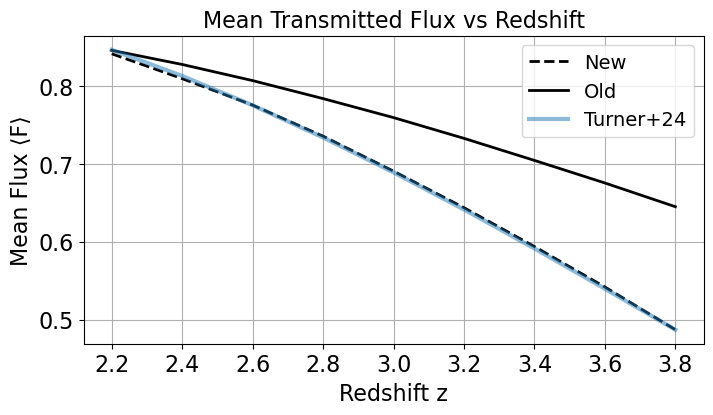

In [35]:
zmin = z_measured_filtered.min()
zmax = z_measured_filtered.max()
zmask1 = (z_filtered >= zmin) & (z_filtered <= zmax)


plt.plot(z_filtered[zmask1], flux_new_filtered[zmask1], '--',
         label='New', lw=2, color='black')

plt.plot(z_filtered[zmask1], flux_measured_interp[zmask1],
         label='Old', lw=2, color='black')

plt.plot(z_filtered[zmask1], turner24_mf(z_filtered[zmask1]), 
         label='Turner+24', lw=3, color='tab:blue', alpha=0.5)

plt.xlabel('Redshift z')
plt.ylabel('Mean Flux ⟨F⟩')
plt.title('Mean Transmitted Flux vs Redshift')
plt.legend()
plt.grid(True)
plt.show()


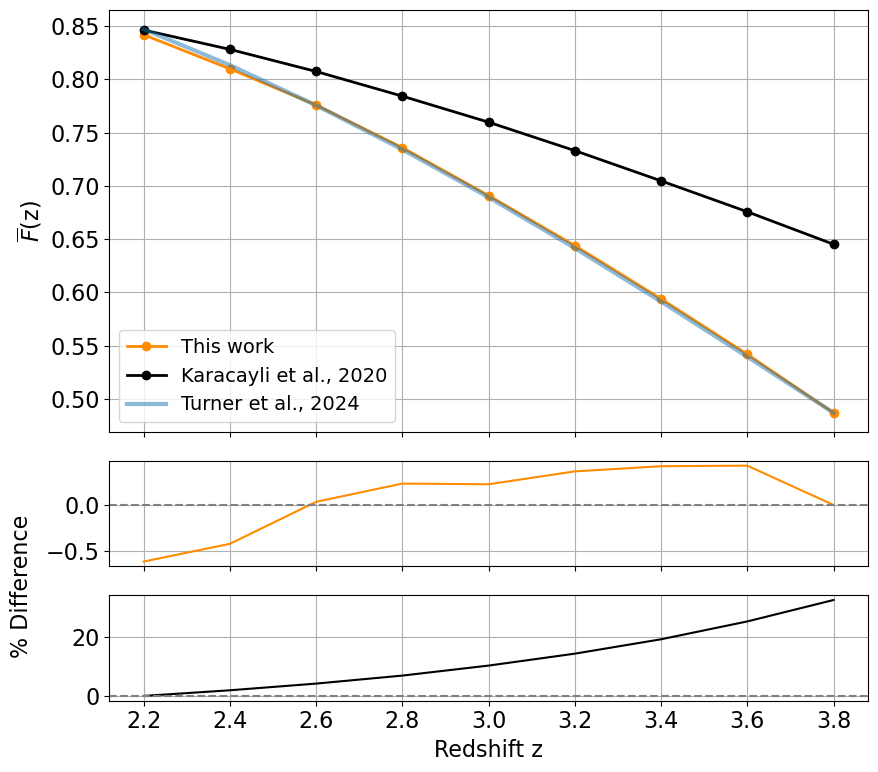

New model:   Mean % diff = 0.075, Max = 0.616
Old model:   Mean % diff = 12.666, Max = 32.497


In [36]:
# Compute percent differences
percent_diff_new = 100 * (flux_new_filtered[zmask1] - turner24_mf(z_filtered[zmask1])) / turner24_mf(z_filtered[zmask1])
percent_diff_old = 100 * (flux_measured_interp[zmask1] - turner24_mf(z_filtered[zmask1])) / turner24_mf(z_filtered[zmask1])

# Create subplots: flux + 2 difference panels
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True,
                                    gridspec_kw={'height_ratios': [4, 1, 1]})

# Plot 1: Mean Flux vs Redshift
ax1.plot(z_filtered[zmask1], flux_new_filtered[zmask1], '-o',
         label='This work', lw=2, color='darkorange')

ax1.plot(z_filtered[zmask1], flux_measured_interp[zmask1], '-o',
         label='Karacayli et al., 2020', lw=2, color='black')

ax1.plot(z_filtered[zmask1], turner24_mf(z_filtered[zmask1]),
         label='Turner et al., 2024', lw=3, color='tab:blue', alpha=0.5)

ax1.set_ylabel(r'$\overline{F}$(z)')
# ax1.set_title('Mean Transmitted Flux vs Redshift')
ax1.legend(loc='lower left')
ax1.grid(True)

# Plot 2: Percent Difference (New - Turner)
ax2.plot(z_filtered[zmask1], percent_diff_new, color='darkorange')
        # ,label='New vs Turner'
# ax2.axhline(percent_diff_new.mean(), ls='--', color='darkorange', label='Mean')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_ylabel('% Δ (New)')
ax2.grid(True)
# ax2.legend(loc='upper left')

# Plot 3: Percent Difference (Old - Turner)
ax3.plot(z_filtered[zmask1], percent_diff_old, color='black')
         # label='Old vs Turner', 
# ax3.axhline(percent_diff_old.mean(), ls='--', color='black', label='Mean')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel('Redshift z')
# ax3.set_ylabel('% Δ (Old)')
ax3.grid(True)
# ax3.legend(loc='upper left')

# Vertical label
fig.text(0.02, 0.25, "% Difference", va='center',
             rotation='vertical', fontsize=16)

plt.tight_layout()
plt.show()

# Optional: summary stats
print(f"New model:   Mean % diff = {percent_diff_new.mean():.3f}, Max = {np.abs(percent_diff_new).max():.3f}")
print(f"Old model:   Mean % diff = {percent_diff_old.mean():.3f}, Max = {np.abs(percent_diff_old).max():.3f}")


In [37]:
# np.min(flux_target_filtered)
np.min((flux_measured_interp - flux_target_filtered) / flux_target_filtered)


-0.01560820048282797

In [38]:
np.min(flux_target_filtered)


0.486997638862637

In [40]:
def abs_rms_error(measured, target):
    return np.sqrt(np.mean((measured - target)**2))

abs_rms_old = abs_rms_error(flux_measured_interp, flux_target_filtered)
abs_rms_new = abs_rms_error(flux_new_filtered, flux_target_filtered)

frac_rms_old = compute_rms_error(flux_measured_interp, flux_target_filtered)
frac_rms_new = compute_rms_error(flux_new_filtered, flux_target_filtered)

print(f"abs rms error old: {abs_rms_old}")
print(f"abs rms error new: {abs_rms_new}\n")

print(f"frac rms error old: {frac_rms_old}")
print(f"frac rms error new: {frac_rms_new}")

abs rms error old: 0.08583204667592545
abs rms error new: 0.0029412828485963216

frac rms error old: 0.15607314662955887
frac rms error new: 0.003852853493961716


In [43]:
abs_rms_old / abs_rms_new

29.18184040575607

In [44]:
frac_rms_old / frac_rms_new

40.508456102512184

In [45]:
def mape(measured, target):
    return np.mean(np.abs((measured - target) / target)) * 100

def MPD(measured, target):
    return np.max(np.abs(100 * (measured - target) / target))

mape_old = mape(flux_measured_interp, flux_target_filtered)
mape_new = mape(flux_new_filtered, flux_target_filtered)

MPD_old = MPD(flux_measured_interp, flux_target_filtered)
MPD_new = MPD(flux_new_filtered, flux_target_filtered)

print(f"MAPE  old: {mape_old}")
print(f"MAPE  new: {mape_new}\n")

print(f"MPD  old: {MPD_old}")
print(f"MPD  new: {MPD_new}")

MAPE  old: 11.574302831028897
MAPE  new: 0.3318706660535595

MPD  old: 32.497361633966705
MPD  new: 0.61587022642543
